# **Data-Intensive Computing Project**

**By: Kailin Wu and Christian Durán García**

## **Project Description**

**PROBLEM STATEMENT**

Customer churn is a real life problem that is affecting every subscription-like business. In a
world where data is being leveraged in almost every aspect of our lives it is possible to find
patterns and understand in a more profound way why certain people just decide to not
renovate subscriptions for certain services. Finding a way to predict whether a customer will
or will not continue with their subscription may allow businesses to address their strategies
accordingly and take countermeasures against the problem. We are both studying a major in
Engineering in Business Digital Transformation, so, having a set of tools like Spark to
generate predictions suitable for businesses seems like a formidable skill to have our future
involvement in the workforce.

**DATA**

The data we plan to use is in the form of two csv files from Kaggle, located in the next link:
https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset

The data is split into training and test data, and evaluation data. Our intent is to use the
evaluation data for simulating real life cases of customer behavior.

**TOOLS**

- Spark and SparkSQL to pre-process and query the data.
- SparkML to generate machine learning algorithms and make predictions.
- Matplotlib and Seaborn to visualize data for a Exploratory Data Analysis.
- Pandas for compatibility with Matplotlib and Seaborn for EDA.
- Streamlit to present our results in a webapp easy to consume.

**METHODOLOGY**

- Collect and read the data using Spark commands.
- Preprocess data with Spark to generate viable data for analysis.
- Query data with SparkSQL to carry on an Exploratory Data Analysis.
- Generate Spark Pandas DataFrames to use visualization libraries.
- Use training and test data to train a model for churn classification using SparkML.
- Generate predictions with the evaluation data simulating real life cases.
- Visualize the historical and predictive data in an executive webapp.

## **Libraries and Data**

In [1]:
# Spark
from pyspark.sql import SparkSession
import findspark

# Solve problem when importing collections in Python 3.10
import collections.abc
#hyper needs the five following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
collections.Callable = collections.abc.Callable

# Data Libraries
import pandas as pd
from collections.abc import Iterable
import matplotlib.pyplot as plt
import seaborn as sns

# Streamlit
import streamlit as st

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Find spark commands
findspark.init()
findspark.find()

'c:\\Users\\cridu.DESKTOP-SDSTA7L\\anaconda3\\lib\\site-packages\\pyspark'

In [2]:
# Create spark session ans visualize the object
spark = SparkSession.builder.appName('Data-Intensive_Project').getOrCreate()

spark

### Data Dictionary
- **CustomerID:** ID of the customer.
- **Age:** Age of the customer.
- **Gender:** Gender of the customer.
- **Tenure:** Period of time that the customer is subscribed.
- **Usage Frequency;** How often the customer use the service.
- **Support Calls:** Number of calls to the call center.
- **Payment Delay:** Days that payment has been delayed.
- **Subscription Type:** Type of subscription the customer has.
- **Contract Length:** Length of the subscription.
- **Total Spend:** Amount spent during the subscription.
- **Last Interaction:** Days since the last interaction with the service.
- **Churn:** Indicates whether a customer has churned or not, a churned customer is one who has decided to discontinue their subscription.

In [3]:
# Read data from csv file
sdf = spark.read.csv('customer_churn_dataset-training-master.csv', header=True, inferSchema=True)

# Show schema
sdf.printSchema()

# Show first 5 rows
sdf.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         2| 30|Female|    39|          

In [4]:
from pyspark.sql.functions import col, count, countDistinct, max

# Describing the whole dataframe
num_cols = [col for col, dtype in sdf.dtypes if dtype in ['int', 'double']]
cat_cols = [col for col, dtype in sdf.dtypes if dtype not in ['int', 'double']]

# Numerical description
num_desc = sdf.select(num_cols).describe()

# Categorical description
cat_desc = sdf.select(cat_cols).agg(
    *[count(col(col_name)).alias(f'count_{col_name}') for col_name in cat_cols],
    *[countDistinct(col(col_name)).alias(f'unique_{col_name}') for col_name in cat_cols],
    *[max(col(col_name)).alias(f'top_{col_name}') for col_name in cat_cols]
)

# Combined description of the dataframe
description = num_desc.crossJoin(cat_desc)

# Show
description.show()

+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------+-----------------------+---------------------+-------------+------------------------+----------------------+----------+---------------------+-------------------+
|summary|        CustomerID|               Age|           Tenure|  Usage Frequency|     Support Calls|     Payment Delay|      Total Spend|  Last Interaction|              Churn|count_Gender|count_Subscription Type|count_Contract Length|unique_Gender|unique_Subscription Type|unique_Contract Length|top_Gender|top_Subscription Type|top_Contract Length|
+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------+-----------------------+---------------------+-------------+------------------------+------------------

## **Data Cleaning**

Dataset is mostly clean due to its nature of a pre-made dataset, but there are still some things we might need to look into before performing any analysis or modeling just yet like:
- Checking for null values.

In [5]:
# Important libraries to perform the following task
from pyspark.sql.functions import isnan, when

# Calculate the number of null values for each column
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdf.columns]).show()

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         1|  1|     1|     1|              1|            1|            1|                1|              1|          1|               1|    1|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



In [6]:
# Defining a function that will help to print out all the rows with null values independently of the column
def get_null_rows(sdf):
    # Condition
    conditions = [col(column).isNull() for column in sdf.columns]
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition = combined_condition | condition

    # Filter df for rows that meet the condition
    null_rows = sdf.filter(combined_condition)

    # Print the number of rows
    print('Number of rows with at least one null value:', null_rows.count())

    # Return rows with null values
    return null_rows

# Display the null rows
get_null_rows(sdf).show()

Number of rows with at least one null value: 1
+----------+----+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID| Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+----+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|      null|null|  null|  null|           null|         null|         null|             null|           null|       null|            null| null|
+----------+----+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



As it can be seen from the output of the previous cell, there is only one null row that has at least one null value. This row has null values for all the columns in the dataset, so, as it is for now, the best way to handle the null values is to simply drop them.

In [7]:
# Dropping null row
sdf = sdf.na.drop()

#  Checking if the operation is successful
get_null_rows(sdf).show()

Number of rows with at least one null value: 0
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



Now that the dataset is fairly clean and does not contain any type of values that may hinder any further analysis, we can procceed to realize the Exploratory Data Analysis.

## **EDA (Exploratory Data Analysis)**

**OVERALL DESCRIPTION FOR THE EXPLORATORY DATA ANALYSIS**

The analysis will be divided in to two main categories:
- Numerical Columns
- Categorical Columns

For each of these categories, some global analysis will be performed, then particular analysis to each variable.

For each relevant numerical variable:
- Descriptive statistics
- Correlations
- Distribution
- Related variables

For each relevant categorical variable:
- Counts
- Unique values
- Related variables
- Creation of categories

### _Numerical Variables_

In [8]:
# Getting a dataframe only with numerical columns
num_cols = [column[0] for column in sdf.dtypes if column[1] in ['int', 'double'] and column[0] != 'CustomerID']

num_sdf = sdf.select(num_cols)

num_sdf.printSchema()

num_sdf.describe().show()

root
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

+-------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+
|summary|               Age|           Tenure|  Usage Frequency|     Support Calls|     Payment Delay|      Total Spend|  Last Interaction|              Churn|
+-------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+
|  count|            440832|           440832|           440832|            440832|            440832|           440832|            440832|             440832|
|   mean|

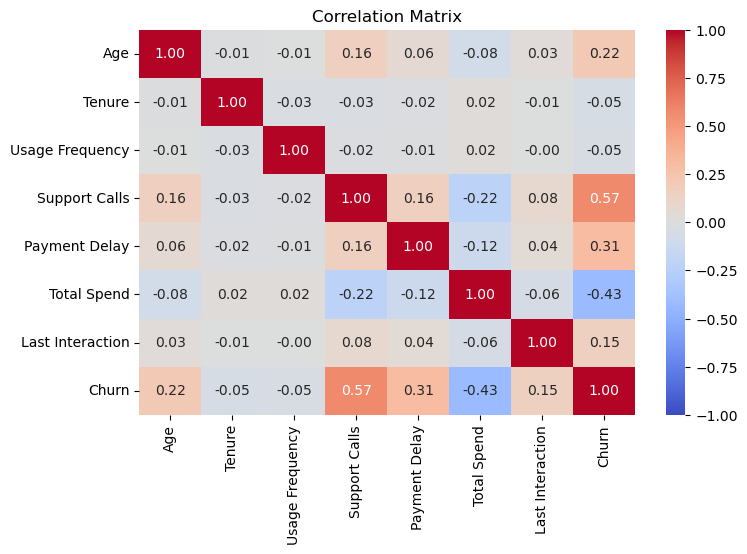

In [9]:
# Function to perform the correlation matrix
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# Creating the vector assembler with the selected columns
vec_assembler = VectorAssembler(inputCols=num_cols, outputCol='features')

# Transform the data into the desired features
num_sdf_transformed = vec_assembler.transform(num_sdf)

# Calculate the correlation matrix
correlations = Correlation.corr(num_sdf_transformed, 'features').collect()[0][0]

# Convert the PySpark dense matrix to a Python List
corr_matrix = correlations.toArray().tolist()

# Create a Pandas DataFrame from the list
corr_matrix_df = pd.DataFrame(corr_matrix, columns=num_cols, index=num_cols)

# Visualize the correlation matrix using seaborn and matplotlib
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix_df, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

From this starting point it seems that most of the numerical variables seem to not be related at all in a linear way.

Two correlations that might be worth looking into are the Churn / Support Cals and Churn / Total Spend.

- Churn / Support Calls has a positive correlation stronger than 0.50, it's not much but with some interpretation we can conclude that seems plausible that a customer is more likely to churn if they need a lot of support from client service.
- Churn / Total Spend has a negative correlation weaker than 0.40, it's not much as well but there can be some connection between users that do not spend much in their subscription and churning.

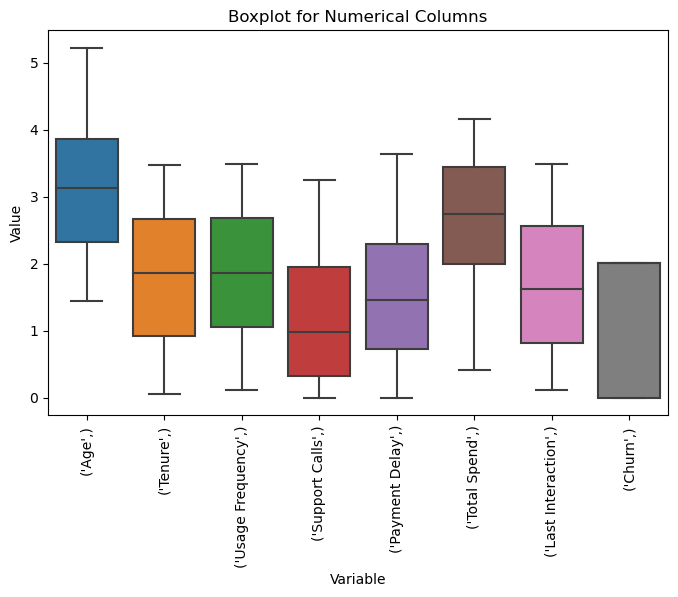

In [10]:
# Visualizing the numerical features in a boxplot, need to use a StandardScaler
from pyspark.ml.feature import StandardScaler, VectorAssembler

vect = VectorAssembler(inputCols=num_cols, outputCol='features')
vect_num_sdf = vect.transform(num_sdf)

scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaled_model = scaler.fit(vect_num_sdf)
scaled_sdf = scaled_model.transform(vect_num_sdf)

scaled_data = scaled_sdf.select('scaled_features').toPandas()

data_for_plot = pd.DataFrame(scaled_data['scaled_features'].tolist(), columns=[num_cols])

plt.figure(figsize=(8,5))
sns.boxplot(data_for_plot);
plt.xticks(rotation=90)
plt.title('Boxplot for Numerical Columns')
plt.ylabel('Value')
plt.xlabel('Variable')
plt.show()

For performing this visualization we decided to use a StandardScaler transformer to put all the data into a single scale and be able to compare it to the other numerical variables. The main insights from this chart are:
- _Age_: Most of the values are concentrated from the middle backwards of the data distribution, so **many customers are young people.**
- _Tenure_: This variable has a fairly **standard distribution.**
- _Usage Frequency_: The **same** as Tenure.
- _Support Calls_: Most of the data are concentrated in the lesser values, meaning that **most of the clients do not make many Support Calls**.
- _Payment Delay_: The same as Support Calls, meaning that **most clients tend to delay few days before paying**.
- _Total Spend_: Most data points fall in the middle upwards part of the distribution, menaning that most of the **customers spend relatively good amounts of money in their service**.
- _Last Interaction_: Follows a fairly **standard distribution.**
- _Churn_: **Binary Feature**.

Now, we can perform this same task excluiding the Churn vairables and instead making a filter with it. This way we can compare the boxplots for both the custumers that churned and the ones who didn't.

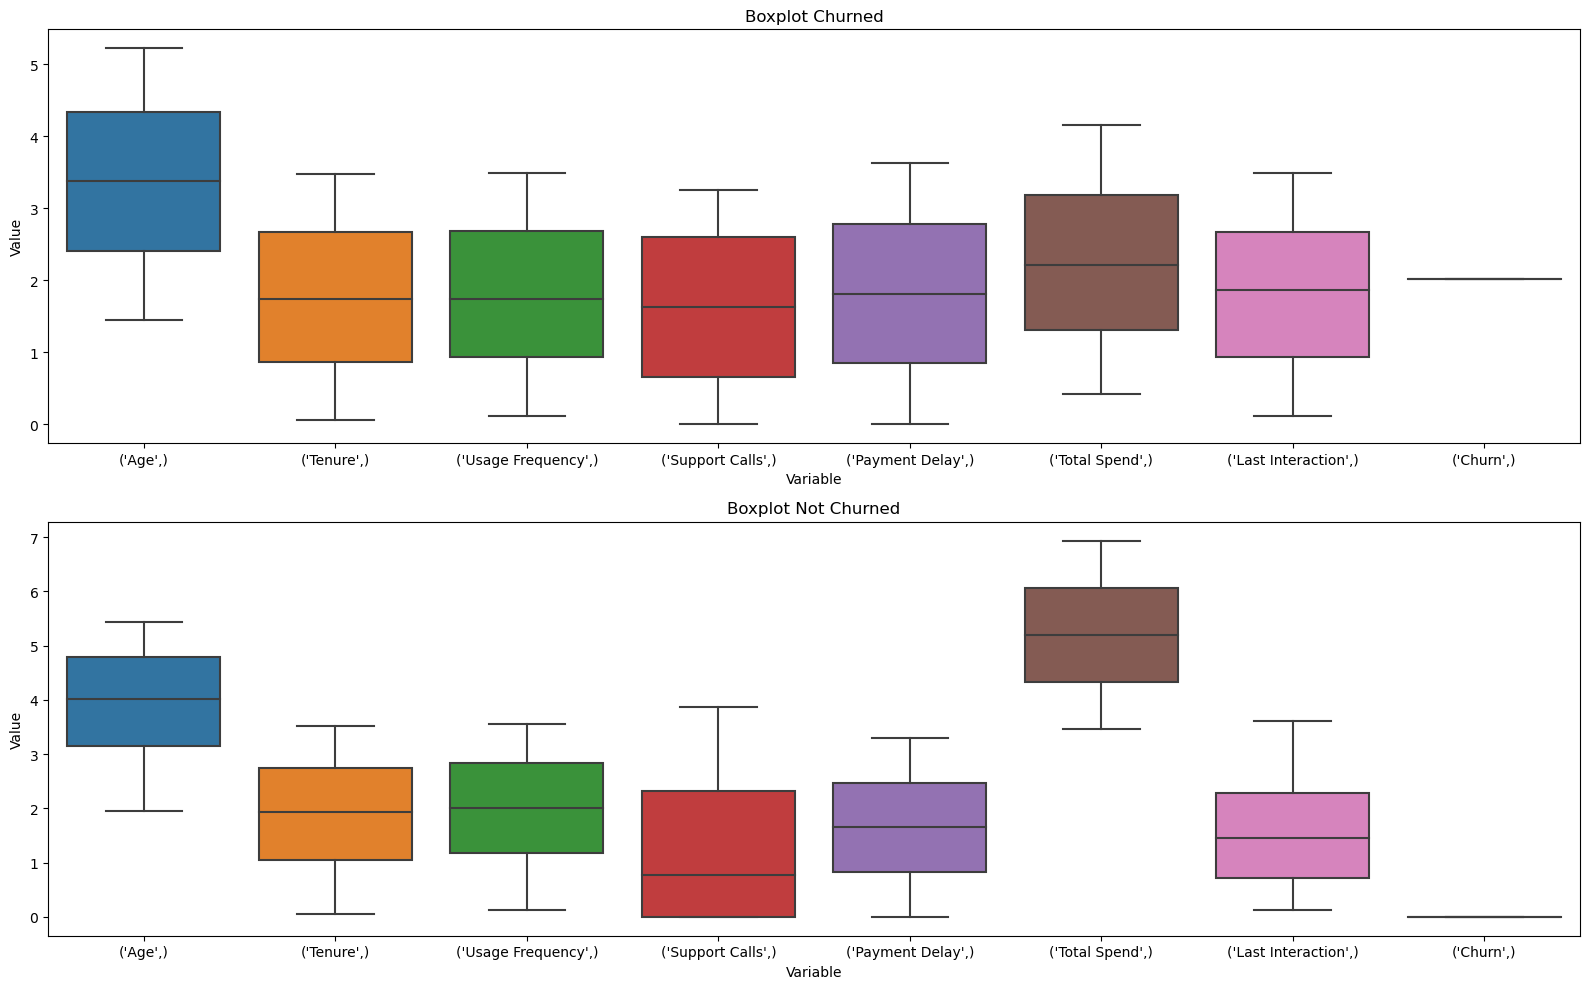

In [11]:
churned = num_sdf.filter('Churn == 1')
not_churned = num_sdf.filter(num_sdf['Churn'] == 0)

vect = VectorAssembler(inputCols=num_cols, outputCol='features')
vect_churned = vect.transform(churned)
vect_not_churned = vect.transform(not_churned)

churned_scaler = StandardScaler(inputCol='features', outputCol='scaled features')
churned_model = churned_scaler.fit(vect_num_sdf)
churned_sdf = churned_model.transform(vect_churned)

not_churned_scaler = StandardScaler(inputCol='features', outputCol='scaled features')
not_churned_model = not_churned_scaler.fit(vect_not_churned)
not_churned_sdf = not_churned_model.transform(vect_not_churned)

scaled_churned = churned_sdf.select('scaled features').toPandas()
scaled_not_churned = not_churned_sdf.select('scaled features').toPandas()

data_churned = pd.DataFrame(scaled_churned['scaled features'].tolist(), columns=[num_cols])
data_not_churned = pd.DataFrame(scaled_not_churned['scaled features'].tolist(), columns=[num_cols])

fig, axes = plt.subplots(2,1,figsize=(16,10))

# Churned data
sns.boxplot(data_churned, ax=axes[0]);
axes[0].set_title('Boxplot Churned')
axes[0].set_ylabel('Value')
axes[0].set_xlabel('Variable')

# Not Churned data
sns.boxplot(data_not_churned, ax=axes[1]);
axes[1].set_title('Boxplot Not Churned')
axes[1].set_ylabel('Value')
axes[1].set_xlabel('Variable')

plt.tight_layout()
plt.show()

This comparison is rather interesting and allows us to see which features differ the most in churned and not churned customers.
- **Churned customers tend to be younger**, whereas the not churned customers are older.
- **Tenure, Usage Frequency, Payment Delay, and Last Interaction variables are much more concentrated towards the mean for not churned customer**s, churned cusotmers have a more disperse behavior.
- **Churned customers make more support calls than not churned ones**, this last group have the mean close to zero, meaning that **most of the customers that renovate the service make little to no support calls**.
- Finally, **not churned customers have a total spend much higher than churned customer**s, if fact the mean spend form not churned customers is higher than the highest spend from the churned customers. This can mean that **not churned customers have loyal to the service for quite some time, where the churned customers only try the service for a spacified period and decide to not renovate it**.

#### Age

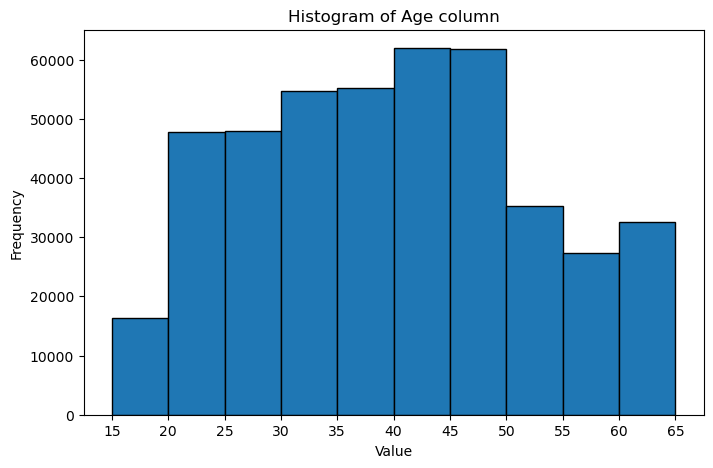

In [12]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Age').toPandas(), bins=range(15,70,5), edgecolor='black')
plt.xticks(range(15,70,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Age column")
plt.show()

#### Tenure

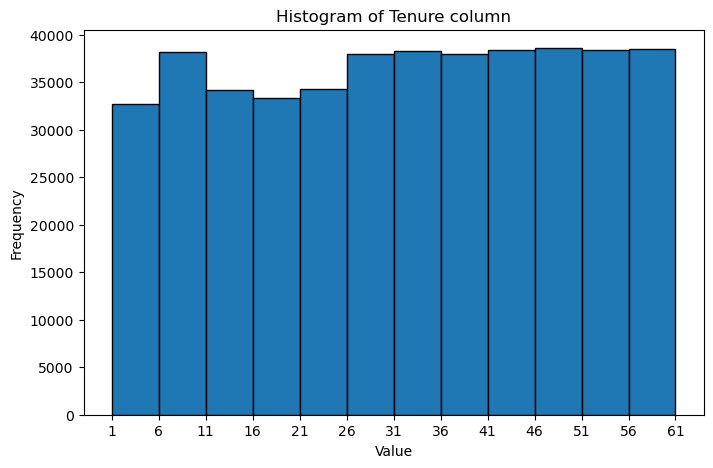

In [13]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Tenure').toPandas(), bins=range(1,65,5), edgecolor='black')
plt.xticks(range(1,65,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Tenure column")
plt.show()

#### Usage Frequency

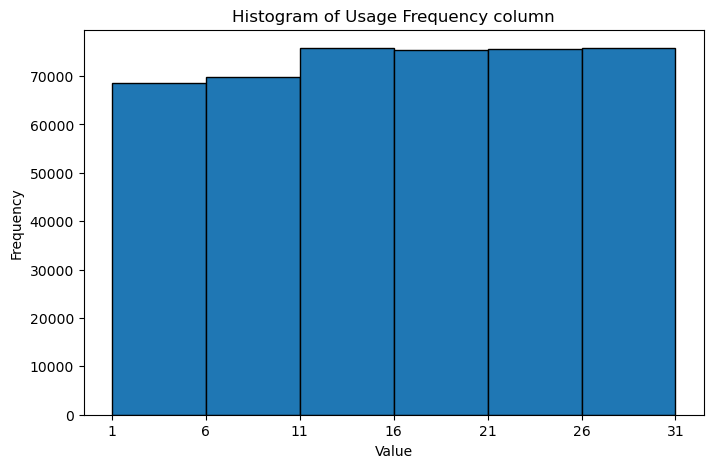

In [14]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Usage Frequency').toPandas(), bins=range(1,35,5), edgecolor='black')
plt.xticks(range(1,35,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Usage Frequency column")
plt.show()

#### Support Calls

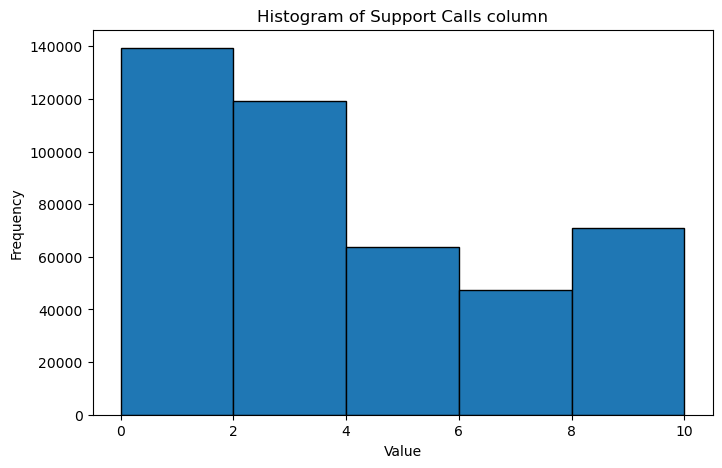

In [15]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Support Calls').toPandas(), bins=range(0,11,2), edgecolor='black')
plt.xticks(range(0,11,2))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Support Calls column")
plt.show()

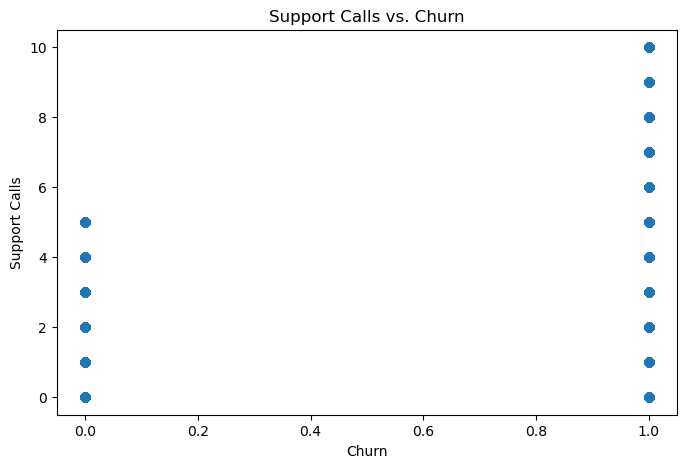

In [16]:
# Plotting the support calls and churn data
plt.figure(figsize=(8,5))
data = num_sdf.select(['Support Calls', 'Churn']).toPandas()
plt.scatter(x=data['Churn'], y=data['Support Calls'])
plt.xlabel("Churn")
plt.ylabel("Support Calls")
plt.title("Support Calls vs. Churn")
plt.show()

We decided to make this graph to further investigate this relationship between Churn and Support Calls. From the visualization is clear to see that the relationship is due to the Binary nature of the Churn variable, also because of the Support Calls trend to have lower values, the latter depicted in the boxplot performed in the global numerical exploration.

There is no point on continuing the exploration of this small linear correlations because of the insights given by this graph, we can tell that all the other graphs will look fairly similar.

#### Payment Delay

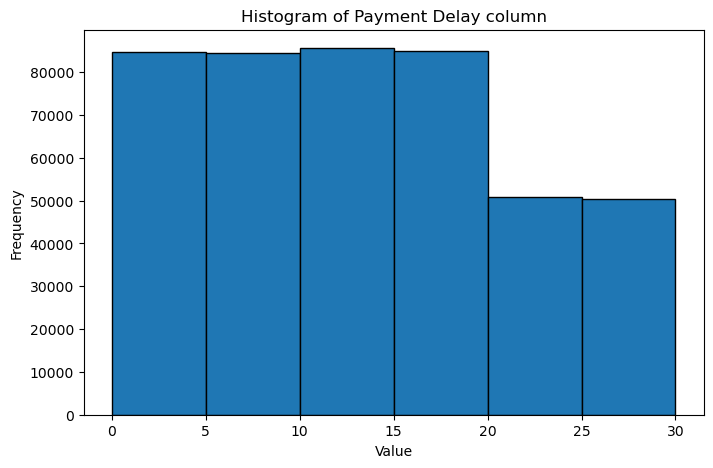

In [17]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Payment Delay').toPandas(), bins=range(0,35,5), edgecolor='black')
plt.xticks(range(0,35,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Payment Delay column")
plt.show()

#### Total Spent

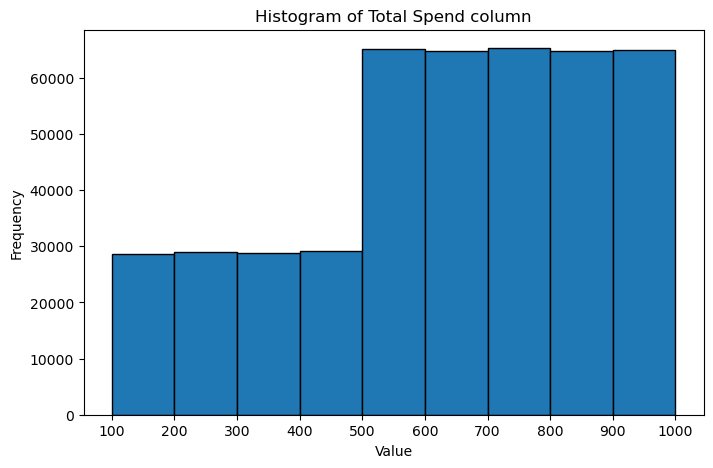

In [18]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Total Spend').toPandas(), bins=range(100,1001,100), edgecolor='black')
plt.xticks(range(100,1001,100))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Total Spend column")
plt.show()

#### Last Interaction

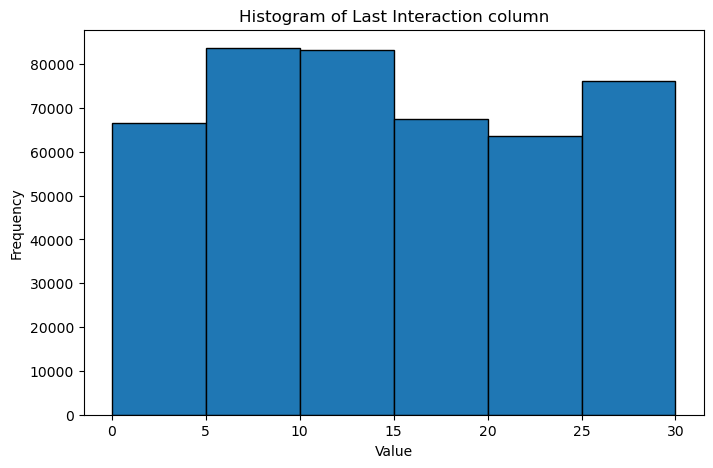

In [19]:
# Visualize the distribution of age in an histogram
plt.figure(figsize=(8,5))
plt.hist(x=num_sdf.select('Last Interaction').toPandas(), bins=range(0,31,5), edgecolor='black')
plt.xticks(range(0,31,5))
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Last Interaction column")
plt.show()

### _Categorical Variables_

In [20]:
# Getting a dataframe only with categorical columns
cat_cols = [column[0] for column in sdf.dtypes if column[1] not in ['int', 'double']]

cat_sdf = sdf.select(cat_cols)

cat_sdf.printSchema()

cat_sdf.show(5)

root
 |-- Gender: string (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)

+------+-----------------+---------------+
|Gender|Subscription Type|Contract Length|
+------+-----------------+---------------+
|Female|         Standard|         Annual|
|Female|            Basic|        Monthly|
|Female|            Basic|      Quarterly|
|  Male|         Standard|        Monthly|
|  Male|            Basic|        Monthly|
+------+-----------------+---------------+
only showing top 5 rows



#### Gender

In [21]:
# Counts of gender
gender = cat_sdf.groupBy('Gender').count()
gender.show()

+------+------+
|Gender| count|
+------+------+
|Female|190580|
|  Male|250252|
+------+------+



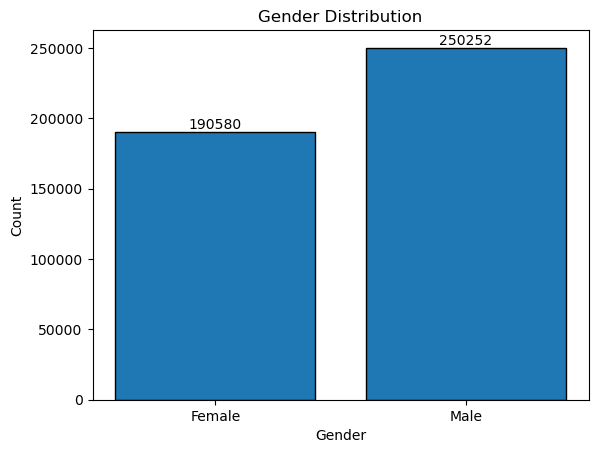

In [22]:
# Bar plot of gender
gender_pd = gender.toPandas()
plt.bar(gender_pd['Gender'], gender_pd['count'], edgecolor='black')

# Add labels to the bars
for i, value in enumerate(gender_pd['count']):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

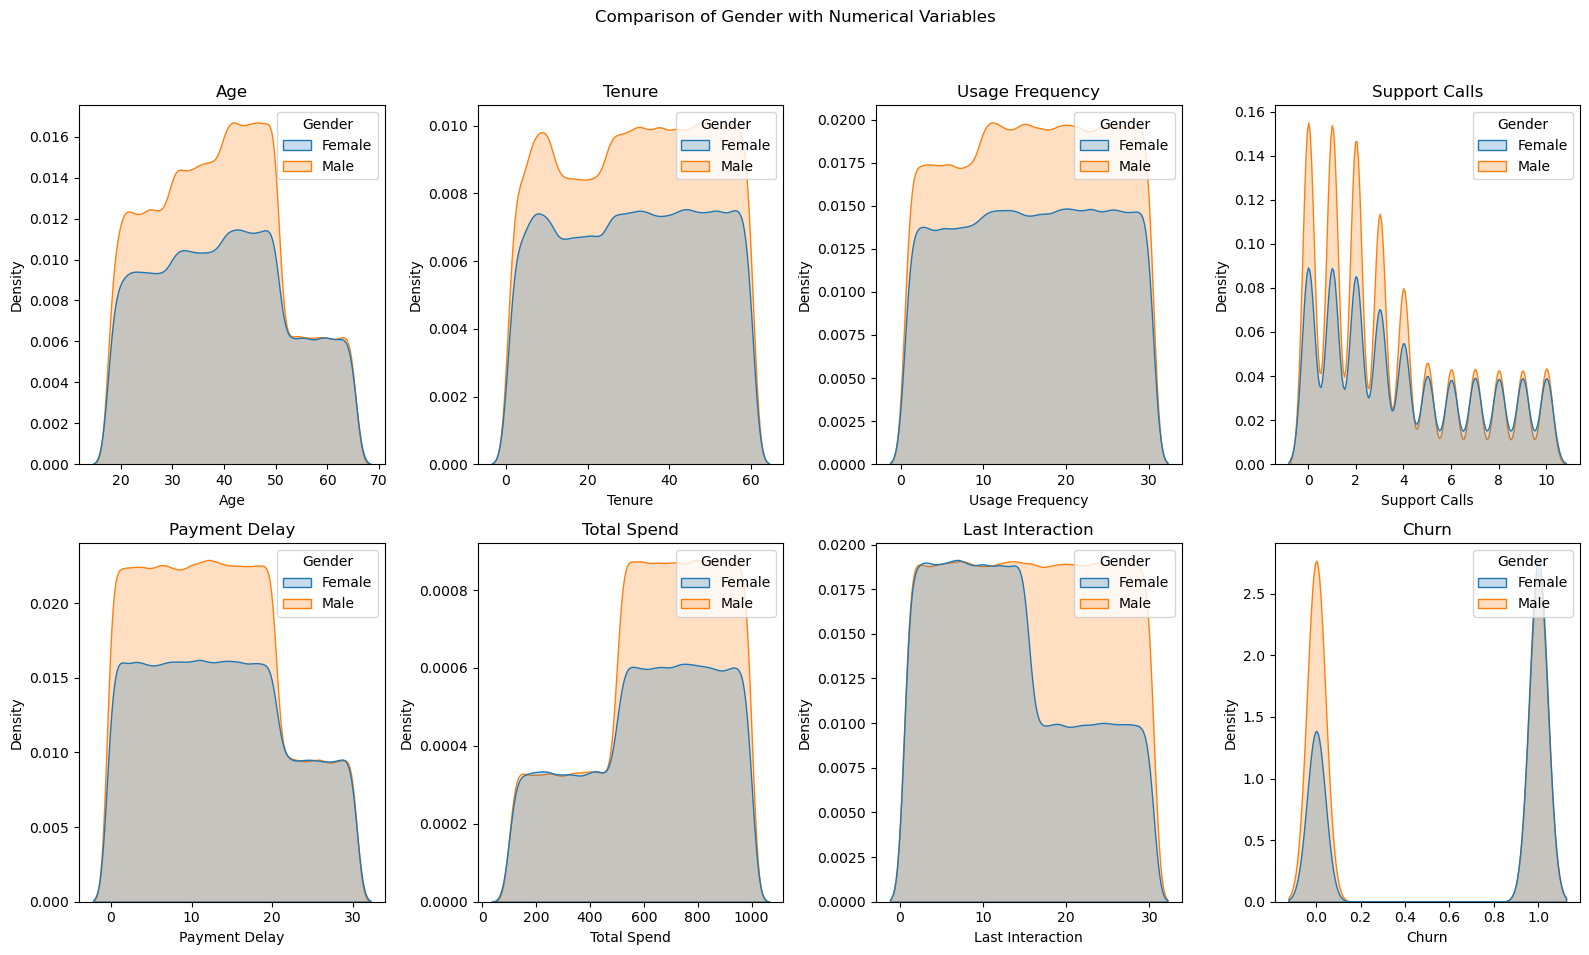

In [23]:
# Comparison with numerical variables
sdf_pd = sdf.toPandas()
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
fig.suptitle('Comparison of Gender with Numerical Variables')

for i, column in enumerate(num_cols):
    row, col = divmod(i,4)
    ax = axes[row, col]

    sns.kdeplot(data=sdf_pd, x=column, hue='Gender', fill=True, ax=ax)
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Density') 

plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

The distribuition between the data of male and female are very similar in most of the numerical variables.
- The most common age is between 50-55 for both gender.
- There're two highest tenure between both gender, the first one is approximately 10, which can be infer as the first subscription. And the second one is between 55-60, who are satisfied customers of the service.
- Both usage frequency are between 10-30.
- The highest amount of support calls are between 0 and 2.
- Payment Delay can be between 0 to 20 days.
- The total spend are between 300-900.
- There's a difference of last interaction between both gender, the last interaction of female are between 0 and 15, and for male are 0-30.
- Most of the female decide to discontinue the service, and for male can be continue or discontinue.

#### Subscription Type

In [24]:
# Counts of subscription type
subscription = cat_sdf.groupBy('Subscription Type').count()
subscription.show()

+-----------------+------+
|Subscription Type| count|
+-----------------+------+
|          Premium|148678|
|            Basic|143026|
|         Standard|149128|
+-----------------+------+



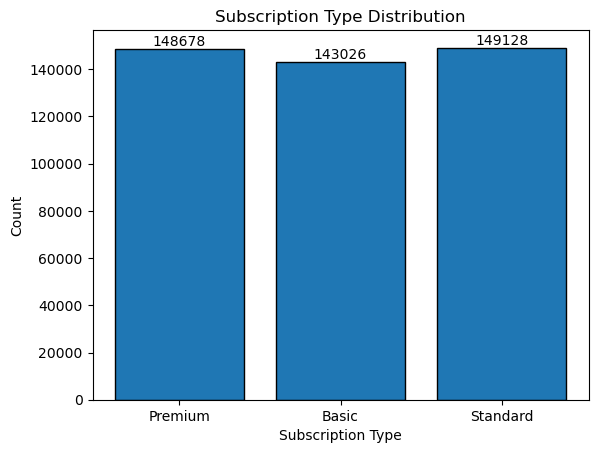

In [25]:
# Bar plot of subscription type
subscription_pd = subscription.toPandas()
plt.bar(subscription_pd['Subscription Type'], subscription_pd['count'], edgecolor='black')

# Add labels to the bars
for i, value in enumerate(subscription_pd['count']):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.title('Subscription Type Distribution')
plt.show()

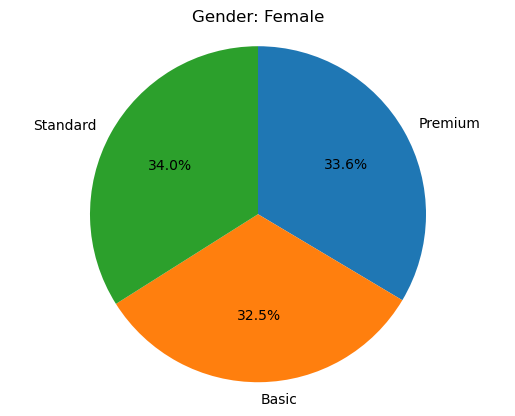

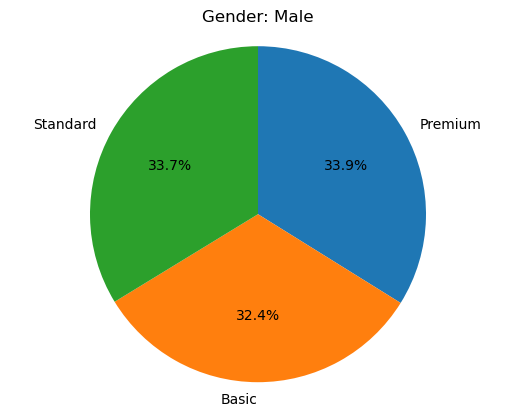

In [26]:
# Get unique subscription types
genders = sdf.select('Gender').distinct().rdd.flatMap(lambda x: x).collect()

# Create a pie chart for each subscription type
for gender in genders:
    # Filter data for the current subscription type
    subset_df = sdf.filter(sdf['Gender'] == gender)

    # Group by Gender and count occurrences
    gender_counts = subset_df.groupBy('Subscription Type').count().toPandas()

    # Create a pie chart
    labels = gender_counts['Subscription Type']
    sizes = gender_counts['count']

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False)

    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Gender: {gender}')

plt.show()

The amount between the 3 types of subscriptions are quite similar and their behavior with the numerical values.

#### Contract Length

In [27]:
# Counts of subscription type
contract = cat_sdf.groupBy('Contract Length').count()
contract.show()

+---------------+------+
|Contract Length| count|
+---------------+------+
|         Annual|177198|
|      Quarterly|176530|
|        Monthly| 87104|
+---------------+------+



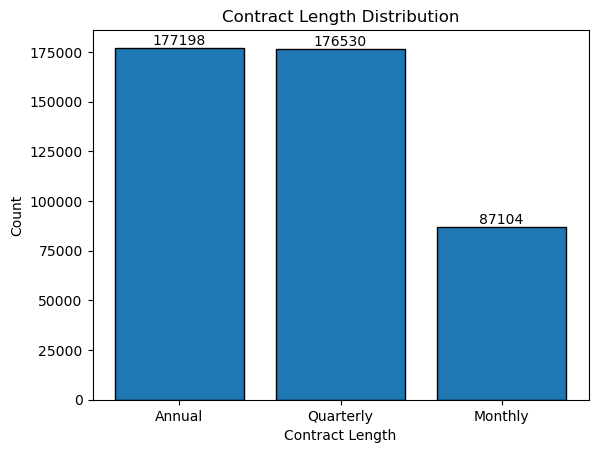

In [28]:
# Bar plot of subscription type
contract_pd = contract.toPandas()
plt.bar(contract_pd['Contract Length'], contract_pd['count'], edgecolor='black')

# Add labels to the bars
for i, value in enumerate(contract_pd['count']):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')
plt.xlabel('Contract Length')
plt.ylabel('Count')
plt.title('Contract Length Distribution')
plt.show()

In [29]:
from pyspark.sql import functions as F

# Define age ranges and labels
age_ranges = [(18, 30), (31, 40), (41, 50), (51, 65)]
labels = ['18-30', '31-40', '41-50', '51-65']

# Create a new column 'AgeGroup' based on age ranges
sdf_with_age_group = sdf.withColumn('AgeGroup', 
                                    F.when((F.col('Age') >= age_ranges[0][0]) & (F.col('Age') <= age_ranges[0][1]), labels[0])
                                    .when((F.col('Age') >= age_ranges[1][0]) & (F.col('Age') <= age_ranges[1][1]), labels[1])
                                    .when((F.col('Age') >= age_ranges[2][0]) & (F.col('Age') <= age_ranges[2][1]), labels[2])
                                    .when((F.col('Age') >= age_ranges[3][0]) & (F.col('Age') <= age_ranges[3][1]), labels[3])
                                    .otherwise('Unknown'))

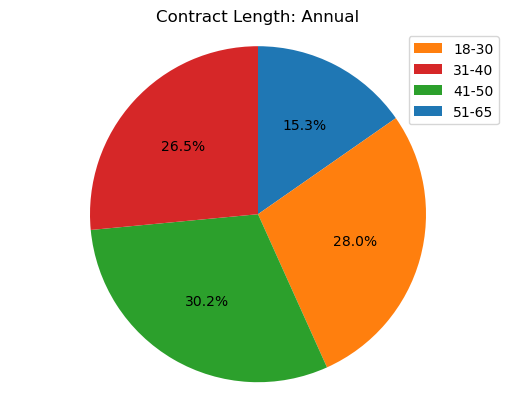

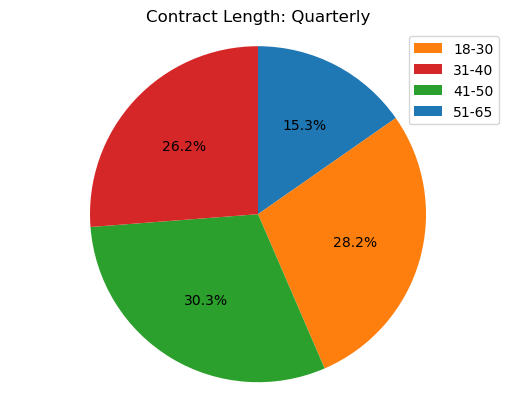

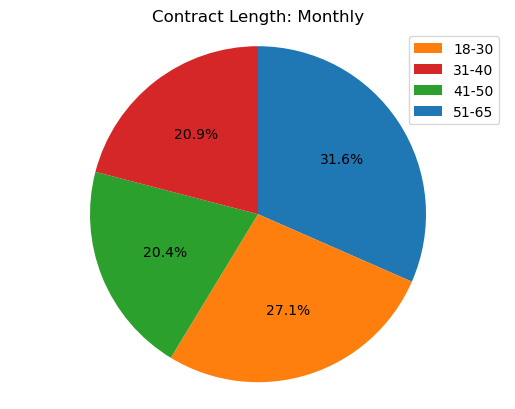

In [30]:
# Get unique subscription types
contracts = sdf_with_age_group.select('Contract Length').distinct().rdd.flatMap(lambda x: x).collect()

# Customer order
label_order = ['18-30', '31-40', '41-50', '51-65']

# Create a pie chart for each subscription type
for contract in contracts:
    # Filter data for the current subscription type
    subset_df = sdf_with_age_group.filter(sdf['Contract Length'] == contract)

    # Group by Gender and count occurrences
    contract_counts = subset_df.groupBy('AgeGroup').count().toPandas()

    # Create a pie chart
    labels = contract_counts['AgeGroup'].tolist()
    sizes = contract_counts['count']

    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, autopct='%1.1f%%', startangle=90, counterclock=False)

    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Contract Length: {contract}')

    # Create custom legend with the correct order
    handles = [wedges[labels.index(label)] for label in label_order]
    labels = label_order
    ax.legend(handles, labels)

plt.show()

## **Modeling**

Now that we have studied the dataset and got a sense of its data distribution and how they are related to one another, and have an idea of the characteristics of both churned and not churned , we can take our next step and try to build a classifier that generalizes the best to the evaluation dataset that contains around 50% of the amount of data available in the training dataset.

To achieve this task we are going to build several classifiers and test them independently to find the one that generalizes the most with the evaluation set. The steps for each classification experiment are:
- Preprocess the data so that it can be fed into each classifier.
- Use a Cross-Validation technique in order to find the model with the best accuracy.
- Use a custom-made function to score the model

### *Data Preprocessing and Feature Selection*

In [42]:
# Presenting schema and dtypes for correct feature selection
sdf.printSchema()
sdf.dtypes

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)



[('CustomerID', 'int'),
 ('Age', 'int'),
 ('Gender', 'string'),
 ('Tenure', 'int'),
 ('Usage Frequency', 'int'),
 ('Support Calls', 'int'),
 ('Payment Delay', 'int'),
 ('Subscription Type', 'string'),
 ('Contract Length', 'string'),
 ('Total Spend', 'double'),
 ('Last Interaction', 'int'),
 ('Churn', 'int')]

In [66]:
# Importing relevant libraries for ML experiments
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Numerical columns
numerical_cols = [column[0] for column in sdf.dtypes if column[1] in ['int', 'double'] and column[0] not in ['Churn']]
categorical_cols = [column[0] for column in sdf.dtypes if column[1] == 'string']

# Create a numerical vector assembler
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='numerical_features')

# Create a StringIndexer for each of the categorical columns
categorical_index = [StringIndexer(inputCol=col, outputCol=col+'_index') for col in categorical_cols]

# OneHotEncode the StringIndexed columns
categorical_ohe = [OneHotEncoder(inputCol=col+'_index', outputCol=col+'_ohe') for col in categorical_cols]

# Categorical assember
categorical_assembler = VectorAssembler(inputCols=[col+'_ohe' for col in categorical_cols], outputCol='categorical_ohe_features')

# Final assembler
assembler = VectorAssembler(inputCols=['numerical_features', 'categorical_ohe_features'], outputCol='features')

# Creating the pipeline
preprocessing = Pipeline(stages=[numerical_assembler] + categorical_index + categorical_ohe + [categorical_assembler, assembler])

# Preprocessing the dataframe
model_df = preprocessing.fit(sdf).transform(sdf).select(['features', 'Churn']).withColumnRenamed('Churn', 'label')

# Visualizing data preprocessing
model_df.show(5)

# Spliting the data into training and testing
train_df, test_df = model_df.randomSplit([0.8, 0.2], seed=42)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.0,30.0,39.0,14...|    1|
|[3.0,65.0,49.0,1....|    1|
|[4.0,55.0,14.0,4....|    1|
|[5.0,58.0,38.0,21...|    1|
|[6.0,23.0,32.0,20...|    1|
+--------------------+-----+
only showing top 5 rows



### *Model Selection and Experimentation*

In [111]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
from pyspark.sql.functions import round
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Creating a custom function to emulate a classification_report from sklearn
def binary_classification_report(predictions, labelCol="label", predictionCol="prediction"):
    # Calculate true positives, true negatives, false positives, and false negatives
    tp = predictions.filter((predictions[labelCol] == 1) & (predictions[predictionCol] == 1)).count()
    tn = predictions.filter((predictions[labelCol] == 0) & (predictions[predictionCol] == 0)).count()
    fp = predictions.filter((predictions[labelCol] == 0) & (predictions[predictionCol] == 1)).count()
    fn = predictions.filter((predictions[labelCol] == 1) & (predictions[predictionCol] == 0)).count()

    # Calculate precision, recall, and F1-score
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate support for each class
    pos_support = tp + fn
    neg_support = tn + fp

    # Calculate overall accuracy
    total_predictions = predictions.count()
    accuracy = (tp + tn) / total_predictions

    # Define the schema for the report DataFrame
    schema = StructType([
        StructField("label", IntegerType(), True),
        StructField("precision", DoubleType(), True),
        StructField("recall", DoubleType(), True),
        StructField("f1-score", DoubleType(), True),
        StructField("support", IntegerType(), True),
        StructField("accuracy", DoubleType(), True)
    ])

    # Create a list of data rows
    report_data = [(0, tn/(tn + fn), tn/(tn + fp), 2*(tn/(tn+fn)*tn/(tn+fp))/(tn/(tn+fn)+tn/(tn+fp)), neg_support, None),
                   (1, precision, recall, f1_score, pos_support, None),
                   (None, None, None, None, total_predictions, accuracy)]

    # Create the DataFrame with the specified schema
    report_df = spark.createDataFrame(report_data, schema)

    # Round up number up to two decimal points
    for col in report_df.columns:
        report_df = report_df.withColumn(col, round(report_df[col], 2))

    return report_df

# Creating a custom function to plot a confusion matrix based on the predictions of a binary classifier
def plot_confusion_matrix(predictions, labelCol="label", predictionCol="prediction"):
    # Calculate true positives, true negatives, false positives, and false negatives
    tp = predictions.filter((predictions[labelCol] == 1) & (predictions[predictionCol] == 1)).count()
    tn = predictions.filter((predictions[labelCol] == 0) & (predictions[predictionCol] == 0)).count()
    fp = predictions.filter((predictions[labelCol] == 0) & (predictions[predictionCol] == 1)).count()
    fn = predictions.filter((predictions[labelCol] == 1) & (predictions[predictionCol] == 0)).count()

    # Elaborate the confusion matrix
    cm = np.array([[tn, fp],
                   [fn, tp]])
    
    # Plot the confusion matrix
    matrix_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
    matrix_plot.plot();
    plt.title('Confusion Matrix');

#### **LogisticRegression**

In [92]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Creating Model
lr = LogisticRegression()

# Parameter grid for logistic regression
lr_grid = (ParamGridBuilder()\
           .addGrid(lr.regParam, [0.1, 0.01, 0.001])\
            .build())

# Evaluator for Cross Validation
evaluator = BinaryClassificationEvaluator()

# Cross Validation
crossval = CrossValidator(estimator=lr, estimatorParamMaps=lr_grid, evaluator=evaluator, numFolds=5)

# Model and predictions
lr_model = crossval.fit(train_df)
lr_predictions = lr_model.transform(test_df)

# Print out report
binary_classification_report(lr_predictions).show()

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.98|  0.98|    0.98|  38243|    null|
|    1|     0.98|  0.98|    0.98|  49983|    null|
| null|     null|  null|    null|  88226|    0.98|
+-----+---------+------+--------+-------+--------+



Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

<Figure size 800x500 with 0 Axes>

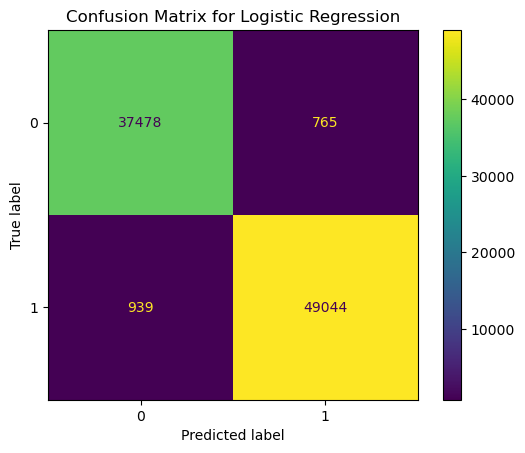

In [112]:
# Plotting the confusion matrix for logistic regression
plt.figure(figsize=(8,5))
plot_confusion_matrix(lr_predictions)
plt.title('Confusion Matrix for Logistic Regression')

In [95]:
# Getting the best hyperparameter for logistic classifier
best_lr_model = lr_model.bestModel
best_reg_param = best_lr_model.getOrDefault('regParam')
print('Best hyperparameter: ', best_reg_param)

Best hyperparameter:  0.001


#### **RandomForestClassifier**

In [97]:
from pyspark.ml.classification import RandomForestClassifier

# Creating Model
rf = RandomForestClassifier()

# Parameter grid for logistic regression
rf_grid = (ParamGridBuilder()\
           .addGrid(rf.maxDepth, [3, 5, 10])\
            .build()) # Relatively low depth to have simpler model

# Evaluator for Cross Validation
evaluator = BinaryClassificationEvaluator()

# Cross Validation
crossval = CrossValidator(estimator=rf, estimatorParamMaps=rf_grid, evaluator=evaluator, numFolds=5)

# Model and predictions
rf_model = crossval.fit(train_df)
rf_predictions = rf_model.transform(test_df)

# Print out report
binary_classification_report(rf_predictions).show()

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|      1.0|  0.98|    0.99|  38243|    null|
|    1|     0.99|   1.0|    0.99|  49983|    null|
| null|     null|  null|    null|  88226|    0.99|
+-----+---------+------+--------+-------+--------+



Text(0.5, 1.0, 'Confusion Matrix for Random Forest')

<Figure size 800x500 with 0 Axes>

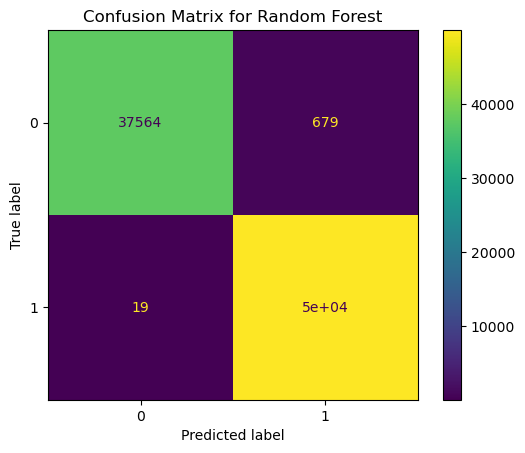

In [113]:
# Plotting the confusion matrix for Random Forest
plt.figure(figsize=(8,5))
plot_confusion_matrix(rf_predictions)
plt.title('Confusion Matrix for Random Forest')

In [98]:
# Getting the best hyperparameter for random forest classifier
best_rf_model = rf_model.bestModel
best_maxDepth_param = best_rf_model.getOrDefault('maxDepth')
print('Best hyperparameter: ', best_maxDepth_param)

Best hyperparameter:  10


#### **NaiveBayes**

In [94]:
from pyspark.ml.classification import NaiveBayes

# Creating Model
nb = NaiveBayes()

# Parameter grid for logistic regression
nb_grid = (ParamGridBuilder()\
           .addGrid(nb.smoothing, [1, 3, 5])\
            .build())

# Evaluator for Cross Validation
evaluator = BinaryClassificationEvaluator()

# Cross Validation
crossval = CrossValidator(estimator=nb, estimatorParamMaps=nb_grid, evaluator=evaluator, numFolds=5)

# Model and predictions
nb_model = crossval.fit(train_df)
nb_predictions = nb_model.transform(test_df)

# Print out report
binary_classification_report(nb_predictions).show()

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.71|  0.96|    0.82|  38243|    null|
|    1|     0.95|  0.71|    0.81|  49983|    null|
| null|     null|  null|    null|  88226|    0.81|
+-----+---------+------+--------+-------+--------+



Text(0.5, 1.0, 'Confusion Matrix for Naive Bayes')

<Figure size 800x500 with 0 Axes>

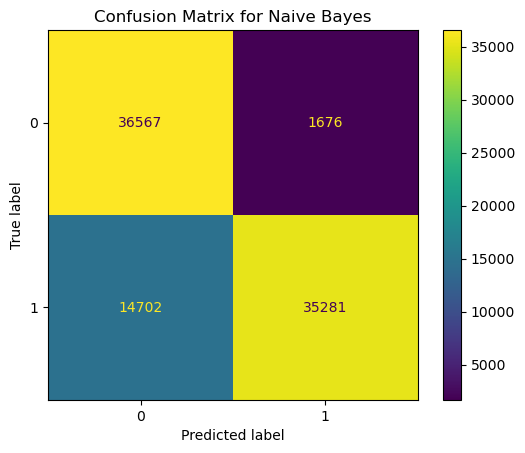

In [114]:
# Plotting the confusion matrix for Naive Bayes
plt.figure(figsize=(8,5))
plot_confusion_matrix(nb_predictions)
plt.title('Confusion Matrix for Naive Bayes')

In [99]:
# Getting the best hyperparameter for naive bayes classifier
best_nb_model = nb_model.bestModel
best_maxDepth_param = best_nb_model.getOrDefault('smoothing')
print('Best hyperparameter: ', best_maxDepth_param)

Best hyperparameter:  1.0


#### **LinearSVC**

In [116]:
from pyspark.ml.classification import LinearSVC

# Creating Model
svc = LinearSVC()

# Parameter grid for logistic regression
svc_grid = (ParamGridBuilder()\
           .addGrid(svc.regParam, [1.0, 0.1, 0.01])\
            .build())

# Evaluator for Cross Validation
evaluator = BinaryClassificationEvaluator()

# Cross Validation
crossval = CrossValidator(estimator=svc, estimatorParamMaps=svc_grid, evaluator=evaluator, numFolds=5)

# Model and predictions
svc_model = crossval.fit(train_df)
svc_predictions = svc_model.transform(test_df)

# Print out report
binary_classification_report(svc_predictions).show()

+-----+---------+------+--------+-------+--------+
|label|precision|recall|f1-score|support|accuracy|
+-----+---------+------+--------+-------+--------+
|    0|     0.97|  0.98|    0.97|  38243|    null|
|    1|     0.99|  0.98|    0.98|  49983|    null|
| null|     null|  null|    null|  88226|    0.98|
+-----+---------+------+--------+-------+--------+



Text(0.5, 1.0, 'Confusion Matrix for Random Forest')

<Figure size 800x500 with 0 Axes>

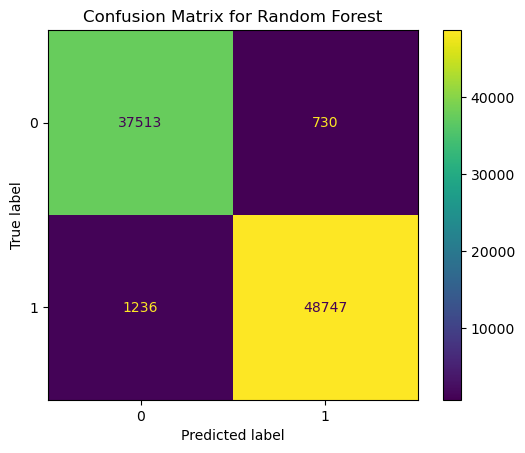

In [118]:
# Plotting the confusion matrix for Linear SVC
plt.figure(figsize=(8,5))
plot_confusion_matrix(svc_predictions)
plt.title('Confusion Matrix for Random Forest')

In [ ]:
# Getting the best hyperparameter for logistic classifier
best_svc_model = svc_model.bestModel
best_reg_param = best_svc_model.getOrDefault('regParam')
print('Best hyperparameter: ', best_reg_param)

Best hyperparameter:  0.1


After performing four experiments we can see how most of the classifiers achieved more than 90% accuracy.

**LogisticRegression** did pretty good, having most of the evaluation metrics at 0.98. This means that it does great classifying both classes.

**RandomForstClassifier** performed much better than LogisticRegression at out first experiment where the depth of each tree in the model was adjusted up to 15, making each DecisionTree very complex. In order to avoid any overfitting in the data we decided to keep the complexity of the trees relatively simple, trying with a maxDepth of 3, 5, and 10; where 10 got the better results.

**NaiveBayes** did not performed really well, we can conclude that this particular classification task is not well suited for a statistical model.

**LinearSVC** did almost as good as LogisticRegression. It did worse in predicting not Churned customers, this is depicted by the lower precision for the 0 class label. Also, the regularization parameter that resulted the best after the cross_validation resulted higher than in LogisticRegression, which means that LinearSVC requieres more regularization than the other model in order to better fit the data, meaning that there is a higher probability that the model overvitted the data.

Now, in order to take this models into a more real-case scenario we will use the evaluation dataset to see how well each model generalizes to the new data.

## **Evaluation**

In [149]:
# Read the evaluation data
eval_sdf = spark.read.csv('customer_churn_dataset-testing-master.csv', header=True, inferSchema=True)

# Size of data
print('Number of rows:', eval_sdf.count())
print('Number of columns:', len(eval_sdf.columns), '\n')

# Show schema
eval_sdf.printSchema()

# Show first 5 rows
eval_sdf.show(5)

Number of rows: 64374
Number of columns: 12 

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: integer (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+

In [150]:
# Calculate the number of null values for each columns
eval_sdf.select([count(when(F.col(c).isNull(), c)).alias(c) for c in eval_sdf.columns]).show()

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         0|  0|     0|     0|              0|            0|            0|                0|              0|          0|               0|    0|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



In [147]:
# Using the previously created preprocessing pipeline to assemble the data properly
eval_df = preprocessing.fit(eval_sdf).transform(eval_sdf).select(['features', 'Churn']).withColumnRenamed('Churn', 'label')

# Visualizing data preprocessing
eval_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,22.0,25.0,14...|    1|
|[2.0,41.0,28.0,28...|    0|
|[3.0,47.0,27.0,10...|    0|
|[4.0,35.0,9.0,12....|    0|
|[5.0,53.0,58.0,24...|    0|
+--------------------+-----+
only showing top 5 rows



#### **LogisticRegression**

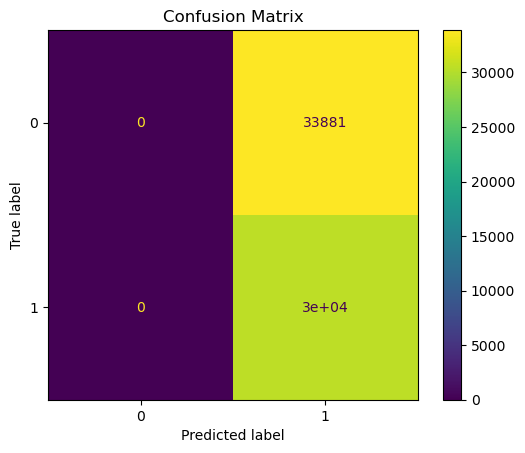

In [159]:
# Generating predictions
eval_pred = best_lr_model.transform(eval_df)

# Classification report
plot_confusion_matrix(eval_pred)

#### **RandomForest**

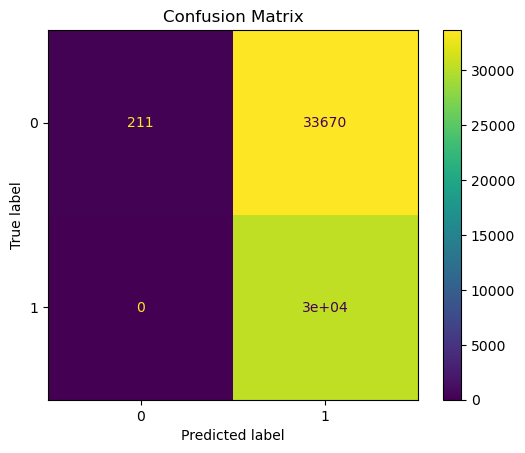

In [155]:
# Generating predictions
eval_pred = best_rf_model.transform(eval_df)

# Classification report
plot_confusion_matrix(eval_pred)

#### **NaiveBayes**

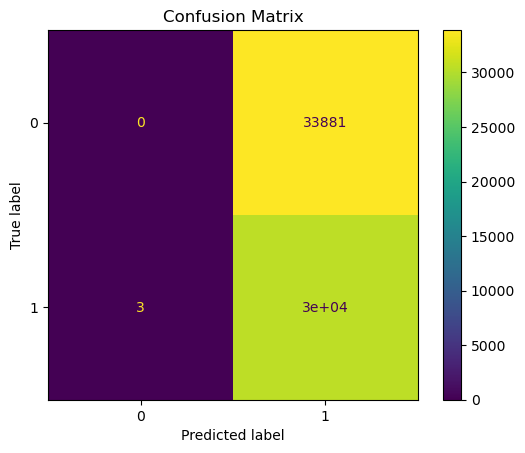

In [156]:
# Generating predictions
eval_pred = best_nb_model.transform(eval_df)

# Classification report
plot_confusion_matrix(eval_pred)

#### **LinearSVC**

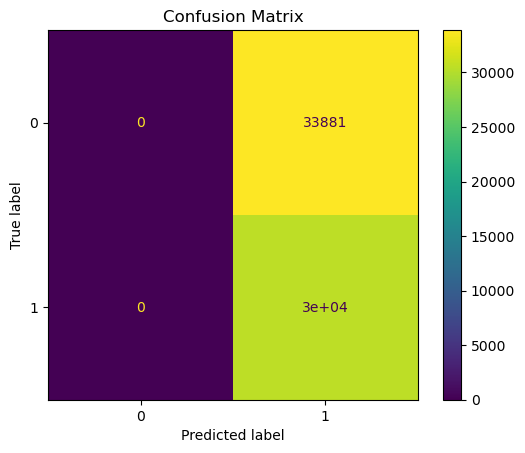

In [157]:
# Generating predictions
eval_pred = best_svc_model.transform(eval_df)

# Classification report
plot_confusion_matrix(eval_pred)